# 6x LLM Request Throughput: Building a Load Balancer for LLM API calls
If you're getting rate limited by OpenAI, this notebook is a tutorial on how to build a load balancer to increase your throughput capacity

* Below you can see using the load balancer leads to a ~6x improvement in successfull LLM API Calls. 391 successfull calls (15%) without the load balancer, 2162 successfull calls (86.5%) with load balancer

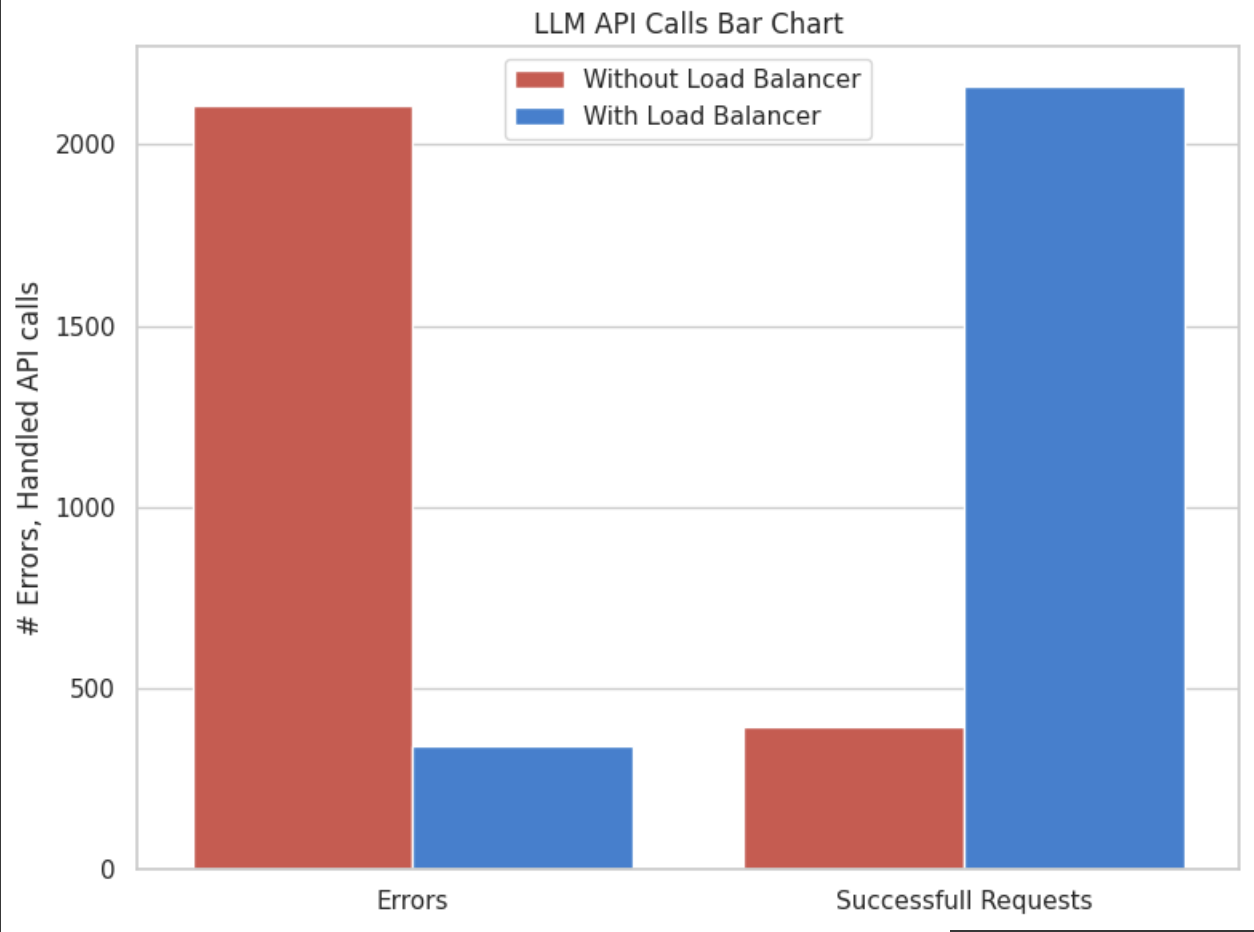



In [ ]:
#@title Env Setup + Installs
!pip install openai cohere seaborn
import openai
import cohere
import seaborn
import time

In [ ]:
#@title List of Sample Questions to use for testing
questions = ['Please create a prompt to create  an instagram post',
 "I'm currently reviewing a project that involves a 1 ha mine site in Queensland, next to a large river fed by a 100 ha catchment area. The model I'm reviewing has a smaller catchment with rain on grid, but I'm unsure how to approach the larger contributing catchment. I need the model to run as quickly as possible and align with Australian government guidelines. Could you provide me with a step-by-step guide on how to review and potentially adjust a 2D model for this scenario, ensuring its accuracy and compliance",
 "I'm currently reviewing a project that involves a 1 ha mine site in Queensland, next to a large river fed by a 100 ha catchment area. The model I'm reviewing has a smaller catchment with rain on grid, but I'm unsure how to approach the larger contributing catchment. I need the model to run as quickly as possible and align with Australian government guidelines. Could you provide me with a step-by-step guide on how to review and potentially adjust a 2D model for this scenario, ensuring its accuracy and compliance",
 "I'm currently reviewing a project that involves a 1 ha mine site in Queensland, next to a large river fed by a 100 ha catchment area. The model I'm reviewing has a smaller catchment with rain on grid, but I'm unsure how to approach the larger contributing catchment. I need the model to run as quickly as possible and align with Australian government guidelines. Could you provide me with a step-by-step guide on how to review and potentially adjust a 2D model for this scenario, ensuring its accuracy and compliance",
 "I'll complete the task during the time I've set myself. If you set me a task after this then I'll complete if the following morning as I'll be at my other work during the evening.",
 "Even last week I kept myself ready during these hours I've mentioned",
 "I've set myself work timings. I start work around 9-10 am pakistan time and end around 3-4 pakistan time. This will cover the hours inshallah. The work you set me will normally be done during this time. If I have to do an airport run or something else I'll let you know the nigth before and I'll complete the work at night inshallah.",
 'The No Child Left Behind Act was a grant program enacted in 2002 that directed testing elementary and secondary students in math and reading proficiency. This act required states to create, fund, and implement programs that would help all students become proficient in these areas by 2014. Describe a power Congress could use to address the information outlined in the scenario. answer: One power of Congress that could use to address the information in the scenario would be distributing funds to states in order for them to be able to abide by the act. In the current scenario, the state is in charge of funding the federal act, but Congress could address this by nationally funding the act. would this earn the point on a frq?',
 'The No Child Left Behind Act was a grant program enacted in 2002 that directed testing elementary and secondary students in math and reading proficiency. This act required states to create, fund, and implement programs that would help all students become proficient in these areas by 2014. Describe a power Congress could use to address the information outlined in the scenario. answer: One power of Congress that could use to address the information in the scenario would be distributing funds to states in order for them to be able to abide by the act. In the current scenario, the state is in charge of funding the federal act, but Congress could address this by nationally funding the act.. would this earn the point on a frq?',
 'The No Child Left Behind Act was a grant program enacted in 2002 that directed testing elementary and secondary students in math and reading proficiency. This act required states to create, fund, and implement programs that would help all students become proficient in these areas by 2014. Describe a power Congress could use to address the information outlined in the scenario. answer: One power of Congress that could use to address the information in the scenario would be distributing funds to states in order for them to be able to abide by the act.  In the current scenario, the state is in charge of funding the federal act, but Congress could address this by nationally funding the act.. would this earn the point on a frq?',
 'What are the causes of primary adrenal insufficiency ?',
 'What are the causes of primary adrenal insufficiency ?',
 'What are the causes of high cholesterol ?',
 "An 18-year-old boy presents with multiple yellow to white skin nodules for the last 8 months. The nodules are painless but have been gradually increasing in size. His eldest sibling has a history of similar nodules; his father died from a myocardial infarction at 38 years of age. His vitals are within the normal range. Examination demonstrates multiple, well-circumscribed, nontender, and mobile nodules on his buttocks and feet. There is a solitary nodule measuring 2 x 1 cm over the right Achilles tendon. Laboratory investigations show a total cholesterol level of 360 mg/dL and a low-density lipoprotein level of 270 mg/dL. A biopsy of the nodules reveals the accumulation of lipid-laden macrophages. Given the likely diagnosis, what is the underlying pathology of this patient's condition?\n\nCorrect answer\n\nA. Reduced clearance of apolipoprotein B100\nB. Increased production of very low-density lipoprotein\nC. Defective low-density lipoprotein receptors\nD. Loss of function mutation in the PCSK9 gene",
 'Who should I call if i have a problem on my pc in m223?',
 'who should i contact if i have a problem in my pc?',
 'who should i contact if i have problem in m223?',
 'Testosterone as part of HRT for women .. (hormone-pellsts subcutaneous) are there any consensus on them?',
 'Fair enough',
 "Write in less than 25 words a joke about your company and how what your company does could help the visiting company's product offering. Start the message with a lowercase letter. Reference previous successful chat conversations for the tone and voice. Mix up the language. Try saying something new to each visitor. Make sure it makes sense. Be as specific as possible. If you don't know the person or the company then write a funny joke based on the person's location. If you don't have the person's location then write a message based on the information of the page the person is on. If you know the person's company mention the person's company in the message. If you don't know the company then don't mention it. Take into account previous chat history and context around the company and the visitor. Do not include any urls in the response. At the very end of the message say '(not a bot btw, real person)'. Speak succinctly as you would to your best friend. Your response to the visitor on the site should be as helpful as possible. If you know the company the person works for or the person's name, include the first name or company name in the message. If the person's name or company is not known, then start the message with 'hey!'. Craft the style of your message as the best sales development representative in the world would write. Do not say the same message twice to the person. Start the response with a lowercase letter.",
 'Give me the indications for HRT in women ?',
 '100% I agree',
 'Testosterone as part of HRT for women hormone pellsts subcutaneous are there any consensus on them?',
 '5.7 Economic Developments and Innovations in the Industrial Age Explain the developments of economic systems, ideologies, and institutions and how they contributed to change. 1. Economic Changes in Global Trade a. Free trade policies and the abandonment of mercantilism due to acceptance of Adam Smith’s theories of laissez-faire capitalism and free markets p382 i. Describe Adam Smith and his theories of laissez-faire capitalism.   ii. How did these theories affect industrialization?     b. Benefits- proliferation of transnational businesses, increased standard of living for some and increased availability, affordability, and variety of consumer goods. (p527-528) i. What was the mass leisure culture and what were their expectations and interests?   ii. How did industrialization produce this culture?     5.8  Reactions to the Industrial Economy from 1750 to 1900 Explain the causes and effects of calls for changes in industrial societies from 1750 to 1900. 1. Calls for Change Ch23 p524-527 a. Political, social, educational, and urban reforms (p524) i. What is the social question? ii. Describe the reforms promoted by the governments and individuals.     b. Worker’s movements and political parties (p522) i. What were the labor movements and how did they help the worker?   ii. How was this new idea passed onto the countryside peasants?   c. Ideologies of Marx.  Define each of these and discuss their significance to the time period and to industrialization (p526) i. Socialism-   ii. Karl Marx-     iii. Communism-     2. Government reform and modernization of economies and militaries a. Ottoman (p593-597) i. Explain each of the reforms that were put in place to try to help the empire survive.   ii. Who are the Young Turks and what effect did they have on the end of the Ottoman Empire?     b. Qing i. (p605-606) What economic changes occurred under the Qing dynasty?   ii. (608-609) Explain the reforms that were attempted and the results of each during the Qing. \u200b 5.9  Society and the Industrial Age Explain how industrialization caused change in existing social hierarchies and standards of living. 1. Adjustments to Industrial Life (p521) a. Describe the changes in social hierarchy that industrialization created, such as family life, material conditions, class structure, etc.   b. As industrialization increased, urbanization increased.  What were the challenges and issues of urbanization as it further developed?   2. Cultural Transformations p526-527 a. Social Classes- Discuss how the middle class and industrial working class developed and changed due to industrialization.   b. Roles of women were altered by industrialization.  Discuss the changes for middle class women and compare them to the changes for working class women.  Also, how were children affected during this time? (Also read p524-525 in the excerpt at the top).       c. Feminism- Explain what feminist movements are and how they developed and gained momentum during industrialization.       IDs- Write the definition and the significance Adam Smith Laissez-faire Karl Marx Socialism Communism Labor unions Tanzimat Reforms Young Turks Emmeline Pankhurst Feminist movements Social question',
 "THE CIVILISED REACTION OF SWEDISH MUSLIM'S PROTEST TO THE BURNING OF THE QURAN...... MASHA-ALLAH MUST WATCH AND SHARE"]

## Regular OpenAI Calls

In [ ]:
openai.api_key = '' #@param
total, processed, errors = 0,0,0
processed_responses = []
error_responses = []

def make_open_ai_call(user_question):
  global total, processed, errors
  total+=1
  start_time = time.time()
  try:
    messages = [
        {"role": "system", "content": 'You are an AI assistant for BerriAI, answer all questions respectfully'},
        {"role": "user", "content" : user_question * 50}
    ]
    response = openai.ChatCompletion.create(model='gpt-3.5-turbo', messages = messages) # Regular OpenAI Calls
    if response != None:
      processed+=1
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"completed {processed}")
      processed_responses.append({'Question': user_question, 'Response': response, 'Response Time': elapsed_time})
  except Exception as e:
    errors+=1
    print(e)
    print(f"\n\nErrors {errors} \n Completed Requests {processed} \n Total Requests{total} \n\n")
    error_responses.append({'Question': user_question, 'Error': e})
    return
  return response

In [ ]:
#@title Make 2500 requests to OpenAI - Get Rate Limited 😊

import concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=2000) as executor:
  futures = [executor.submit(make_open_ai_call, question) for question in questions*100]
  concurrent.futures.wait(futures)



In [ ]:
#@title Normal API Calls had a 84.3% Error Rate 😥
print(f"Made Total Requests: {total} \nSuccessfull Requests: {processed}\nFailed Requests: {errors}")

Made Total Requests: 2500 
Successfull Requests: 391
Failed Requests: 2109


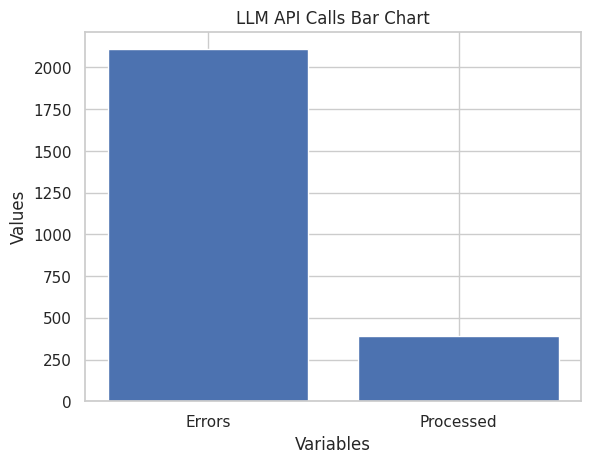

In [ ]:
#@title Bar Chart of Processed Calls, Errors
import matplotlib.pyplot as plt

def create_bar_chart(errors, total, processed):
    # Data for the bar chart
    labels = ['Errors', 'Processed']
    values = [errors, processed]

    # Create the bar chart
    plt.bar(labels, values)

    # Add labels and title
    plt.xlabel('Variables')
    plt.ylabel('Values')
    plt.title('LLM API Calls Bar Chart')

    # Show the chart
    plt.show()

# Create and display the bar chart
create_bar_chart(errors, total, processed)


# Load Balancer Implementation - to use Azure, OpenAI, Cohere
This load balancer does the following:

*   Maintains a priority list of LLM models (earlier models in fallback_strategy get tried first)
*   Tries to make API calls with all models in fallback_strategy (across providers Azure, OpenAI, Cohere)
* Sets Cooldowns for 60s for rate limited models - if a model has been throwing errors this script sets a 60s cooldown for the selected model



In [ ]:
def load_balancer(user_question):
  messages = [
        {"role": "system", "content": 'You are an AI assistant for BerriAI, answer all questions respectfully'},
        {"role": "user", "content" : user_question * 50}
  ]
  response = None
  rate_limited_models = set()
  model_expiration_times = {}
  fallback_strategy=['chatgpt-test', 'gpt-3.5-turbo', 'chatgpt-v-2', 'command-nightly']
  start_time = time.time()
  while response == None and time.time() - start_time < 45:
    for model in fallback_strategy:
      # loop thru all models
        try:
          if model in rate_limited_models: # check if model is currently cooling down
            if model_expiration_times.get(model) and time.time() >= model_expiration_times[model]:
                rate_limited_models.remove(model) # check if it's been 60s of cool down and remove model
            else:
                continue # skip model
          if model == 'chatgpt-v-2' or model == 'chatgpt-test':
            # azure configs
            openai.api_type = "azure"
            openai.api_base = "your azure base"  #@param
            openai.api_version = "your azure version" #@param
            openai.api_key = ""  #@param
            response = openai.ChatCompletion.create(
              engine=model,
              messages = messages
            )
          elif model == 'command-nightly':
            cohere_key =  ""#@param
            co = cohere.Client(cohere_key)
            prompt = " ".join([message["content"] for message in messages])
            response = co.generate(
              model=model,
              prompt = prompt,
              max_tokens=200
            )
            response = response.generations[0].text
          else:
            # regular configs
            openai.api_type = "openai"
            openai.api_base = "https://api.openai.com/v1"
            openai.api_version = None
            openai.api_key =  ""#@param
            if model == 'text-davinci-003':
              prompt = " ".join([message["content"] for message in messages])
              response = openai.Completion.create(
                model=model,
                prompt = prompt
              )
            else:
              response = openai.ChatCompletion.create(
                model=model,
                messages = messages
              )
          if response != None:
            return response

        except Exception as e:
          print(f"got exception {e}")
          rate_limited_models.add(model)
          model_expiration_times[model] = time.time() + 60 # cool down this selected model
          print(f"rate_limited_models {rate_limited_models}")
          pass

  return response

In [ ]:
#@title Test Load balancer with an API call
response = load_balancer("who are u")
print(response)

In [ ]:
#@title Make 2500 requests to Azure, OpenAI, Cohere - 10x Througput 🍇
import concurrent.futures

total_2, processed_2, errors_2 = 0,0,0
processed_responses_2 = []
error_responses_2 = []

def make_LLM_request(user_question):
  global total_2, processed_2, errors_2
  total_2+=1
  start_time = time.time()
  try:
    response = load_balancer(user_question)
    if response != None:
      processed_2 +=1
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"completed {processed_2}")
      processed_responses_2.append({'Question': user_question, 'Response': response, 'Response Time': elapsed_time})
    else:
      errors_2+=1
      print(f"\n\nErrors {errors_2} \n Completed Requests {processed_2} \n Total Requests{total_2} \n\n")
      error_responses_2.append({'Question': user_question, 'Error': 'Load Balancer Failed'})

  except Exception as e:
    errors_2+=1
    print(e)
    print(f"\n\nErrors {errors_2} \n Completed Requests {processed_2} \n Total Requests{total_2} \n\n")
    error_responses_2.append({'Question': user_question, 'Error': e})
    return
  return response


with concurrent.futures.ThreadPoolExecutor(max_workers=2000) as executor:
  futures = [executor.submit(make_LLM_request, question) for question in questions*100]
  concurrent.futures.wait(futures)



In [ ]:
print(f"Made Total Requests: {total_2} \nSuccessfull Requests: {processed_2}\nFailed Requests: {errors_2}")

Made Total Requests: 2500 
Successfull Requests: 2162
Failed Requests: 338


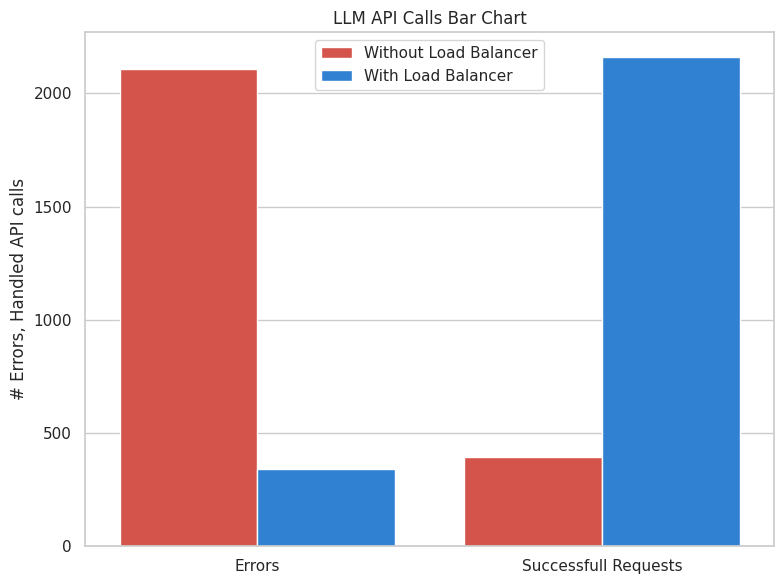

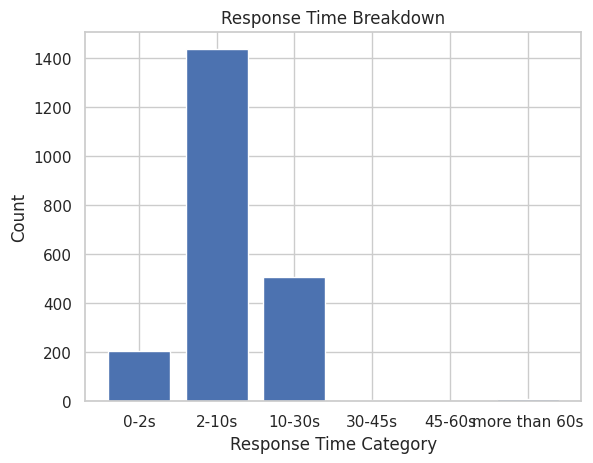

In [ ]:
#@title Bar Chart of Processed Calls, Errors with Load Balancer: 6x Improvement 😲
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def create_bar_chart(errors, processed, errors_2, processed_2):
    # Data for the bar chart
    labels = ['Errors', 'Successfull Requests']
    values_1 = [errors, processed]
    values_2 = [errors_2, processed_2]

    # Combine the data into a single DataFrame
    data = {
        'Variables': labels * 2,
        'Values': values_1 + values_2,
        'Load Balancer': ['Without Load Balancer'] * len(labels) + ['With Load Balancer'] * len(labels)
    }

    # Create a bar plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Variables', y='Values', hue='Load Balancer', data=data, palette={'With Load Balancer': '#1581ed', 'Without Load Balancer': '#eb4034'})

    # Add title and labels
    plt.ylabel('# Errors, Handled API calls')
    plt.title('LLM API Calls Bar Chart')

    # Show the chart
    plt.tight_layout()
    plt.legend()
    plt.show()

# Example usage:
create_bar_chart(errors, processed, errors_2, processed_2)



import matplotlib.pyplot as plt
import pandas as pd

df_1 = pd.DataFrame(processed_responses_2)


# Define the time categories
categories = ['0-2s', '2-10s', '10-30s', '30-45s', '45-60s', 'more than 60s']

# Bucket the response times into categories
df_1['Category'] = pd.cut(df_1['Response Time'], bins=[0, 2, 10, 30, 45, 60, float('inf')], labels=categories)

# Count the occurrences of each category
category_counts = df_1['Category'].value_counts().sort_index()

# Plotting the bar chart
plt.bar(category_counts.index, category_counts)

# Adding labels and title
plt.xlabel('Response Time Category')
plt.ylabel('Count')
plt.title('Response Time Breakdown')

# Displaying the chart
plt.show()
